In [1]:
import os, json
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
import itertools
from sklearn.metrics.cluster import fowlkes_mallows_score
from sklearn.cluster import KMeans, DBSCAN, OPTICS
import utility

%run fm_index.ipynb
%run hopkins.ipynb

In [4]:
# Load experimental data
path_to_json = '/chompsky/techno/development/work/clustering-data-cleaning/build/normalized' 
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]

data = pd.DataFrame(columns=['base_uuid', 'clusters', 'participant', 'unique_uuid', 'group'])

# we need both the json and an index number so use enumerate()
index = 0
for _, js in enumerate(json_files):
    with open(os.path.join(path_to_json, js)) as json_file:
        json_data = json.load(json_file)
        for sample in json_data:
            if sample["flipped"]:
                unflipped = []
                for cluster in sample["clusters"]:
                    unflipped.append(list(map(lambda p: {"x": 800 - p["x"], "y": 500 - p["y"]}, cluster)))
                sample["clusters"] = unflipped
            data.loc[index] = np.array((sample["base_uuid"], sample["clusters"], sample["participant_id"], sample['unique_uuid'], sample['group']))
            index += 1
            # print(sample["clusters"])
            # for cluster in sample["clusters"]:
            #     plt.scatter(list(p["x"] for p in cluster), list(p["y"] for p in cluster))
        # # here you need to know the layout of your json and each json has to have
        # # the same structure (obviously not the structure I have here)


<ipython-input-4-f0eb54ef955d>:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data.loc[index] = np.array((sample["base_uuid"], sample["clusters"], sample["participant_id"], sample['unique_uuid'], sample['group']))


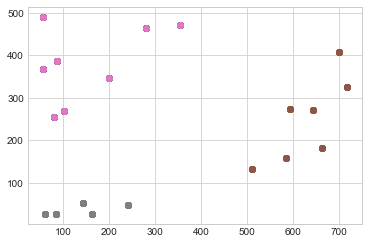

In [5]:
for row in data.loc[data['base_uuid'] == "37ecaaa0-dbb1-4b98-ad55-ce73229d5866"].iterrows():
    clusters = row[1][1]
    for cluster in clusters:
        plt.scatter(list(p["x"] for p in cluster), list(p["y"] for p in cluster))




In [6]:
k_means_df = pd.DataFrame(columns=["base_uuid", "points", "clusters"])

np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

# Run K-Means on each stimulus
index = 0
stimuli = data.drop_duplicates(subset=['base_uuid'])
for row in stimuli.iterrows():
    clusters = row[1][1]
    points = []
    for cluster in clusters:
        for p in cluster:
            points.append([p["x"], p["y"]])
    clustered = KMeans(len(clusters)).fit(points)
    for ind, p in enumerate(points):
        p.append(clustered.labels_[ind])
    k_means_df.loc[index] = np.array((row[1][0], points, np.array(clustered.labels_, dtype="object")))
    index += 1



In [8]:
# Run DBScan on each stimulus
db_scan_df = pd.DataFrame(columns=["base_uuid", "points", "clusters"])

np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

# Run DBScan on each stimulus
index = 0
stimuli = data.drop_duplicates(subset=['base_uuid'])
for row in stimuli.iterrows():
    clusters = row[1][1]
    points = []
    for cluster in clusters:
        for p in cluster:
            points.append([p["x"], p["y"]])
    clustered = DBSCAN(10).fit(points) # eps value may need tweaking/vary on it
    for ind, p in enumerate(points):
        p.append(clustered.labels_[ind])
    db_scan_df.loc[index] = np.array((row[1][0], points, np.array(clustered.labels_, dtype="object")))
    index += 1



In [9]:
# Run OPTICS on each stimulus
optics_df = pd.DataFrame(columns=["base_uuid", "points", "clusters"])

np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

# Run DBScan on each stimulus
index = 0
stimuli = data.drop_duplicates(subset=['base_uuid'])
for row in stimuli.iterrows():
    clusters = row[1][1]
    points = []
    for cluster in clusters:
        for p in cluster:
            points.append([p["x"], p["y"]])
    clustered = OPTICS().fit(points) # eps value may need tweaking/vary on it
    for ind, p in enumerate(points):
        p.append(clustered.labels_[ind])
    optics_df.loc[index] = np.array((row[1][0], points, np.array(clustered.labels_, dtype="object")))
    index += 1



In [13]:
# FMScore on KMeans/DBScan/Optics vs samples

fm_data = pd.DataFrame(columns=["base_uuid", "kmeans_fm_score", "dbscan_fm_score", "optics_fm_score", "group"])

uuids = data[["base_uuid"]]
index = 0
for index, uuid in uuids.iterrows():
    uuid = uuid["base_uuid"]
    # print(uuid)
    filtered_data = data.loc[data["base_uuid"] == uuid]
    # print(uuid)
    # break
    cluster1_km = np.array(list(k_means_df.loc[k_means_df["base_uuid"] == uuid]["points"]))[0]
    cluster1_db = np.array(list(db_scan_df.loc[db_scan_df["base_uuid"] == uuid]["points"]))[0]
    cluster1_opt = np.array(list(optics_df.loc[optics_df["base_uuid"] == uuid]["points"]))[0]
    # print(cluster1_km)
    # break
    samples = set(filtered_data["unique_uuid"])
    for sample_uuid in samples:
        cluster2 = list(filtered_data.loc[filtered_data["unique_uuid"] == sample_uuid]["clusters"])[0]
        fm_data.loc[index] = np.array(
            (uuid, \
            float(utility.calc_fowlkes_mallows(cluster1_km, cluster2)), \
            float(utility.calc_fowlkes_mallows(cluster1_db, cluster2)), \
            float(utility.calc_fowlkes_mallows(cluster1_opt, cluster2)), \
            filtered_data.iloc[0]["group"]))
        index += 1

    # for sample in data.loc[data['base_uuid'] == uuid].iterrows():
        # print(row)

# avg over pairs of clusterings in base_uuid's samples

# cc = list(itertools.combinations(uuids, 2))
# print(cc)
# pd.DataFrame([data.loc[c,:].sum() for c in cc], index=cc)
fm_data['kmeans_fm_score'] = pd.to_numeric(fm_data['kmeans_fm_score'])
fm_data['dbscan_fm_score'] = pd.to_numeric(fm_data['dbscan_fm_score'])
fm_data['optics_fm_score'] = pd.to_numeric(fm_data['optics_fm_score'])






,base_uuid,kmeans_fm_score,dbscan_fm_score,optics_fm_score,group
0,823dc71a-6c2e-42ea-910b-4e53f7bd4a90,0.535942,0.703375,0.546460,disperse
1,fccbc907-4526-43e2-8ded-142b804b471a,1.000000,0.421637,0.421637,clustered
2,e0b28b0d-8194-475b-98a6-6931d1ff1004,0.794719,0.632456,0.613388,clustered
3,b3697dbc-04ee-4762-a98d-5773cf0c7e84,1.000000,0.516398,0.516398,clustered
4,37ecaaa0-dbb1-4b98-ad55-ce73229d5866,0.767674,0.676679,0.713641,clustered
...,...,...,...,...,...
5260,49f28baf-c341-4fb1-a75b-0ff70240de39,0.670166,0.688247,0.525955,disperse
5261,6b397277-e2cf-4165-9f1a-32aeef65ebbc,1.000000,0.802773,0.581318,clustered
5262,e9bc8099-ff66-4017-abd4-33cd8dbcc2d6,0.647576,0.556776,0.737978,clustered
5263,6da3f9dc-e910-4c46-822b-eebee4448324,0.554799,0.539468,0.548991,clustered


In [15]:
fm_data.to_csv('null_hypothesis_data.csv')

In [11]:
fm_data = pd.DataFrame(columns=["base_uuid", "fm_score", "group"])
fm_data['fm_score'] = fm_data['fm_score'].astype(float)

uuids = data[["base_uuid"]]
index = 0
for index, uuid in uuids.iterrows():
    uuid = uuid["base_uuid"]
    # print(uuid)
    filtered_data = data.loc[data["base_uuid"] == uuid]
    # if len(filtered_data) > 0:
    #     points = np.array(np.concatenate(filtered_data.iloc[0]["clusters"]).flat)
    #     print(points)
    #     hopkins_statistic = hopkins(points)
    # print(filtered_data)
    cc = list(itertools.combinations(set(filtered_data["unique_uuid"]), 2))
    for pair in cc:
        # print(pair)
        cluster1 = list(data.loc[data["unique_uuid"] == pair[0]]["clusters"])[0]
        cluster2 = list(data.loc[data["unique_uuid"] == pair[1]]["clusters"])[0]

        fm_data.loc[index] = np.array((uuid, float(fm_index_points(cluster1, cluster2)), filtered_data.iloc[0]["group"]))
        index += 1

    # for sample in data.loc[data['base_uuid'] == uuid].iterrows():
        # print(row)

# avg over pairs of clusterings in base_uuid's samples

# cc = list(itertools.combinations(uuids, 2))
# print(cc)
# pd.DataFrame([data.loc[c,:].sum() for c in cc], index=cc)
fm_data['fm_score'] = pd.to_numeric(fm_data['fm_score'])


fm_data.head()


,base_uuid,fm_score,group
0,823dc71a-6c2e-42ea-910b-4e53f7bd4a90,0.592506,disperse
1,fccbc907-4526-43e2-8ded-142b804b471a,0.525226,clustered
2,e0b28b0d-8194-475b-98a6-6931d1ff1004,0.834058,clustered
3,b3697dbc-04ee-4762-a98d-5773cf0c7e84,1.000000,clustered
4,37ecaaa0-dbb1-4b98-ad55-ce73229d5866,0.767674,clustered


In [37]:

summary = fm_data.groupby(['base_uuid', 'group']).agg({ 'fm_score': ['count', 'mean', 'std', 'median']})
print(summary)


                                               fm_score                 \
                                                  count      mean  std   
base_uuid                            group                               
0f18f0ad-f23d-4fc9-a761-3920c107550b clustered       94  0.673331  0.0   
0f9a9c80-cdab-4071-8d56-27965b585a10 disperse        94  0.687682  0.0   
2bb1495b-1ef6-4943-bb48-662371f50b30 clustered       94  0.605530  0.0   
2f24428f-632d-4374-b0ca-cb3d0ae04bc5 disperse        94  0.690066  0.0   
2f452eee-c0bb-437c-bd4e-f35ee9fe9ff6 clustered       94  0.517648  0.0   
3088609a-8abd-42eb-9289-926728077ed5 disperse        94  0.617213  0.0   
339f68e4-98bf-4d4a-81c7-06fa958f307e clustered       94  1.000000  0.0   
37ce66b3-c54a-46ec-981d-96c33e8fba81 disperse        94  0.626835  0.0   
37ecaaa0-dbb1-4b98-ad55-ce73229d5866 clustered       93  1.000000  0.0   
3808a1ab-27ce-451f-bbd1-525f0e658c07 clustered       94  0.457749  0.0   
3c4d6c38-877b-41d2-b2b5-d2f74ef0970b c

In [42]:
# plot mean across all of them
plt.bar(list(p[1] for p in summary))


TypeError: bar() missing 1 required positional argument: 'height'